# PET ROI SUV Statistics

This notebook will take in ROI files (NIfTI format) and calculate SUV statistics on the PET scan.

## Introduction

In this notebook, we will:
1. Load ROI files in NIfTI format.
2. Load the corresponding PET scan.
3. Calculate SUV statistics for the regions of interest.



## 1. Convert PET DICOM scans to NIFTI format
### NIFTI files will allow us to access the raw PET data in a more accessible format

In [1]:
#home_dir = "/Volumes/T7 Shield/UC Davis COVID Study/"
home_dir = "E:/UC Davis COVID Study/"
PET_path = home_dir + "Segmentations and PET NIFTIs/PET NIFTI Files/"

In [10]:
import dicom2nifti as d2n
import os

counter = 0
with os.scandir(home_dir) as entries:
    for entry in entries:
        if entry.is_dir():
            #print(entry.name)
            
            group_dir = os.path.join(home_dir, entry)
            with os.scandir(group_dir) as patients:
                for patient in patients:
                    if patient.is_dir():
                        #print(patient)

                        patient_dir = os.path.join(group_dir, patient)
                        with os.scandir(patient_dir) as scan_times:
                            for scan_time in scan_times:
                                if scan_time.is_dir():
                                    #print(scan_time.name)

                                    scan_dir = os.path.join(patient_dir, scan_time)
                                    with os.scandir(scan_dir) as scans:
                                        for scan in scans:
                                            if scan.is_dir():
                                                if scan.name[:3] == "SUV":
                                                    DICOM = os.path.join(scan_dir, scan.name)
                                                    segmentName = scan_dir.replace(home_dir, '').replace('/','_')
                                                    print(segmentName)
                                                    saveOutput = os.path.join(PET_path, segmentName)
                                                    os.makedirs(saveOutput, exist_ok=True)
                                                    d2n.convert_directory(DICOM, saveOutput)
                                                    counter = counter + 1


#output_path = "/Users/williamlee/Documents/UC Davis COVID Study/COVID Patients/1697954_FDG_COVID_Pt002_JP/20121026/"
#output_path = "/Volumes/T7 Shield/UC Davis COVID Study/Segmentations/NIFTI Segmentations/"

#d2n.convert_directory(PET_path, output_path)

#print(f'DICOM files from {PET_path} have been converted to NIfTI format and saved to {output_path}')

COVID Patients_1697954_FDG_COVID_Pt010_KH_20130503
COVID Patients_1697954_FDG_COVID_Pt010_KH_20130105
COVID Patients_1697954_FDG_COVID_Pt008_NT_20130429
COVID Patients_1697954_FDG_COVID_Pt008_NT_20121227
COVID Patients_1697954_FDG_COVID_Pt003_LC_20121029
COVID Patients_1697954_FDG_COVID_Pt003_LC_20130228
COVID Patients_1697954_FDG_COVID_Pt014_LO_20130418
COVID Patients_1697954_FDG_COVID_Pt014_LO_20130818
COVID Patients_1697954_FDG_COVID_Pt007_ZB_20121222
COVID Patients_1697954_FDG_COVID_Pt007_ZB_20130426
COVID Patients_1697954_FDG_COVID_Pt006_CB_20130506
COVID Patients_1697954_FDG_COVID_Pt006_CB_20130104
COVID Patients_1697954_FDG_COVID_Pt002_JP_20121026
COVID Patients_1697954_FDG_COVID_Pt002_JP_20130223
COVID Patients_1697954_FDG_COVID_Pt018_MW_20130915
COVID Patients_1697954_FDG_COVID_Pt018_MW_20130517
COVID Patients_1697954_FDG_COVID_Pt004_MR_20130411
COVID Patients_1697954_FDG_COVID_Pt004_MR_20121129
COVID Patients_1697954_FDG_COVID_Pt009_VB_20130118
COVID Patients_1697954_FDG_COVI

## 2. Load ROI files and convert PET scans to SUV values
## Using the corresponding DICOM PET file for each patient for metadata, we can convert the raw PET values into SUV values corresponding to each patients scan

In [3]:
# Segmentation Map
total_segmentator_names = [
    "background",
    "spleen",
    "kidney_right",
    "kidney_left",
    "gallbladder",
    "liver",
    "stomach",
    "pancreas",
    "adrenal_gland_right",
    "adrenal_gland_left",
    "lung_upper_lobe_left",
    "lung_lower_lobe_left",
    "lung_upper_lobe_right",
    "lung_middle_lobe_right",
    "lung_lower_lobe_right",
    "esophagus",
    "trachea",
    "thyroid_gland",
    "small_bowel",
    "duodenum",
    "colon",
    "urinary_bladder",
    "prostate",
    "kidney_cyst_left",
    "kidney_cyst_right",
    "sacrum",
    "vertebrae_S1",
    "vertebrae_L5",
    "vertebrae_L4",
    "vertebrae_L3",
    "vertebrae_L2",
    "vertebrae_L1",
    "vertebrae_T12",
    "vertebrae_T11",
    "vertebrae_T10",
    "vertebrae_T9",
    "vertebrae_T8",
    "vertebrae_T7",
    "vertebrae_T6",
    "vertebrae_T5",
    "vertebrae_T4",
    "vertebrae_T3",
    "vertebrae_T2",
    "vertebrae_T1",
    "vertebrae_C7",
    "vertebrae_C6",
    "vertebrae_C5",
    "vertebrae_C4",
    "vertebrae_C3",
    "vertebrae_C2",
    "vertebrae_C1",
    "heart",
    "aorta",
    "pulmonary_vein",
    "brachiocephalic_trunk",
    "subclavian_artery_right",
    "subclavian_artery_left",
    "common_carotid_artery_right",
    "common_carotid_artery_left",
    "brachiocephalic_vein_left",
    "brachiocephalic_vein_right",
    "atrial_appendage_left",
    "superior_vena_cava",
    "inferior_vena_cava",
    "portal_vein_and_splenic_vein",
    "iliac_artery_left",
    "iliac_artery_right",
    "iliac_vena_left",
    "iliac_vena_right",
    "humerus_left",
    "humerus_right",
    "scapula_left",
    "scapula_right",
    "clavicula_left",
    "clavicula_right",
    "femur_left",
    "femur_right",
    "hip_left",
    "hip_right",
    "spinal_cord",
    "gluteus_maximus_left",
    "gluteus_maximus_right",
    "gluteus_medius_left",
    "gluteus_medius_right",
    "gluteus_minimus_left",
    "gluteus_minimus_right",
    "autochthon_left",
    "autochthon_right",
    "iliopsoas_left",
    "iliopsoas_right",
    "brain",
    "skull",
    "rib_left_1",
    "rib_left_2",
    "rib_left_3",
    "rib_left_4",
    "rib_left_5",
    "rib_left_6",
    "rib_left_7",
    "rib_left_8",
    "rib_left_9",
    "rib_left_10",
    "rib_left_11",
    "rib_left_12",
    "rib_right_1",
    "rib_right_2",
    "rib_right_3",
    "rib_right_4",
    "rib_right_5",
    "rib_right_6",
    "rib_right_7",
    "rib_right_8",
    "rib_right_9",
    "rib_right_10",
    "rib_right_11",
    "rib_right_12",
    "sternum",
    "costal_cartilages"
]

In [2]:
import nibabel as nib
import numpy as np
import pydicom
from datetime import datetime
import os
from scipy import interpolate
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider, Dropdown
import IPython
from IPython.display import display, clear_output
from matplotlib.cm import ScalarMappable


# Upscale SUV values (256,256) to segmentation mask resolution (512,512)
def upscale_suv_values_3d(suv_values, new_shape):
    # Get the shape of the original SUV values array
    original_shape = suv_values.shape
    
    # Create arrays of coordinates for the original and new SUV values arrays
    x = np.linspace(0, 1, original_shape[0])
    y = np.linspace(0, 1, original_shape[1])
    z = np.linspace(0, 1, original_shape[2])
    
    new_x = np.linspace(0, 1, new_shape[0])
    new_y = np.linspace(0, 1, new_shape[1])
    new_z = np.linspace(0, 1, new_shape[2])
    
    # Create meshgrids of the coordinates
    x_mesh, y_mesh, z_mesh = np.meshgrid(x, y, z, indexing='ij')
    new_x_mesh, new_y_mesh, new_z_mesh = np.meshgrid(new_x, new_y, new_z, indexing='ij')
    
    # Interpolate the SUV values to the new coordinates in each dimension
    suv_interpolated = np.zeros(new_shape)
    for i in range(original_shape[2]):
        suv_interpolated[:, :, i] = interpolate.interpn((x, y), suv_values[:, :, i], (new_x_mesh[:, :, i], new_y_mesh[:, :, i]), method='linear', bounds_error=False, fill_value=None)
    
    return suv_interpolated

def load_nifti_file(filepath):
    """Load a NIfTI file and return the data array."""
    nifti_img = nib.load(filepath)
    data = nifti_img.get_fdata()
    return data
    
def calculate_time_difference(scan_time_str, injection_time_str):
    # Define the correct time format
    time_format_with_microseconds = "%H%M%S.%f"
    time_format_without_microseconds = "%H%M%S"

    # Parse the time strings with and without microseconds
    try:
        scan_time = datetime.strptime(scan_time_str, time_format_with_microseconds)
    except ValueError:
        scan_time = datetime.strptime(scan_time_str, time_format_without_microseconds)

    try:
        injection_time = datetime.strptime(injection_time_str, time_format_with_microseconds)
    except ValueError:
        injection_time = datetime.strptime(injection_time_str, time_format_without_microseconds)

    # Remove the fractional seconds by setting microseconds to zero
    scan_time = scan_time.replace(microsecond=0)
    
    # Subtract the two datetime objects
    time_difference = scan_time - injection_time

    # Get the total difference in seconds
    total_seconds = time_difference.total_seconds()

    return total_seconds

def convert_raw_PET_to_SUV(pet_dicom, pet_nifti):
    PET_data = load_nifti_file(pet_nifti)
    print(pet_dicom)
    full_path = os.path.join(pet_dicom, os.listdir(pet_dicom)[0])
    ds = pydicom.dcmread(full_path)
    
    # Get Scan time (Osirix uses SeriesTime, but can change to AcquisitionTime. Series time seems more precise)
    # scantime = parse_time(ds.SeriesTime)
    # # Start Time for the Radiopharmaceutical Injection
    # injection_time = parse_time(ds.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartTime)

    time_diff = abs(calculate_time_difference(ds.SeriesTime, ds.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartTime))
    print(ds.SeriesTime)
    print(ds.RadiopharmaceuticalInformationSequence[0].RadiopharmaceuticalStartTime)
    
    # Half Life for Radionuclide # seconds
    half_life = float(ds.RadiopharmaceuticalInformationSequence[0].RadionuclideHalfLife) 
    # Total dose injected for Radionuclide
    injected_dose = float(ds.RadiopharmaceuticalInformationSequence[0].RadionuclideTotalDose)
    
    # Calculate dose decay correction factor
    decay_correction_factor = np.exp(-np.log(2)*((time_diff)/half_life))

    print("half_life: ",half_life)
    #print("scan_time: ", scantime)
    #print("injection time: ", injection_time)
    print("minus time", (time_diff))
    
    patient_weight = ds.PatientWeight * 1000
    SUV_factor = (patient_weight) / (injected_dose * decay_correction_factor)


    
    print("decay_correction factor ", decay_correction_factor) 
    print("SUV factor is:", SUV_factor)
    return(PET_data * SUV_factor)

def calculate_suv_statistics(roi_data, pet_data):
    """Calculate SUV statistics for each unique ROI."""
    #print(roi_data)
    unique_rois = np.arange(0, 118)
    suv_stats = {}
    
    for roi in unique_rois:
        print("Working on roi: ", total_segmentator_names[roi])
        print(roi)
        if roi == 0:
            continue  # Skip the background

        if roi == 10 or roi == 11 or roi == 12 or roi == 13 or roi == 14:
            roi_mask = roi_data == roi
            suv_values = pet_data[roi_mask]
            if len(suv_values) == 0:
                mean_suv = None
                max_suv = None
                median_suv = None
                num_val = None
            else:
                mean_suv = np.mean(suv_values)
                max_suv = np.max(suv_values)
                median_suv = np.median(suv_values)
                num_val = len(suv_values)
            
            
            suv_stats[total_segmentator_names[int(roi)]] = {
                'mean': mean_suv,
                'max': max_suv,
                'median': median_suv,
                'num_val': num_val
            }
    return suv_stats

# Function to parse time with or without fractional seconds
def parse_time(time_str):
    try:
        # Try parsing with fractional seconds
        return datetime.datetime.strptime(time_str, '%H%M%S.%f')
    except ValueError:
        # Fallback to parsing without fractional seconds
        return datetime.datetime.strptime(time_str, '%H%M%S')

# Helper function that takes in an organ and SUV values of a single patient and extracts the correct statitistics. Adapted to extract total lung weighted avg across lobes (lung) as well as all vertebrae and rib
def extractPatientStats(suvs, organ, stat):
    if organ == "lung":
        val1 = suvs['lung_upper_lobe_left'][stat]
        val1num = suvs['lung_upper_lobe_left']['num_val']
        val2 = suvs['lung_lower_lobe_left'][stat]
        val2num = suvs['lung_lower_lobe_left']['num_val']
        val3 = suvs['lung_upper_lobe_right'][stat]
        val3num = suvs['lung_upper_lobe_right']['num_val']
        val4 = suvs['lung_middle_lobe_right'][stat]
        val4num = suvs['lung_middle_lobe_right']['num_val']
        val5 = suvs['lung_lower_lobe_right'][stat]
        val5num = suvs['lung_lower_lobe_right']['num_val']
        avg = (val1*val1num + val2*val2num + val3*val3num + val4*val4num + val5*val5num)/(val1num+val2num+val3num+val4num+val5num)
        return avg
    if organ == "vertebrae" or "rib":
        rawVals = []
        numVals = []
        for name in total_segmentator_names:
            if name.startswith(organ):
                val = suvs[name][stat]
                rawVals.append(val)
                numVal = suvs[name]['num_val']
                numVals.append(numVal)
        numerator = 0
        denominator = 0
        for idx,val in enumerate(rawVals):
            numerator = numerator + (rawVals[idx] * numVals[idx])
            denominator = denominator + numVals[idx]
        #print("length of vertebrae ", len(numVals))
        return (numerator/denominator)
    else:
        return suvs[organ][stat]

def visualize_array(array):
    # Define a function to plot a heatmap of a given layer
    def plot_heatmap(layer, axis):
        clear_output(wait=True)  # Clear the previous output without flashing
        fig, ax = plt.subplots(figsize=(8, 6))
        im = None
        vmin, vmax = np.min(array), np.max(array) * 0.2  # Determine vmin and vmax for entire array
    
        if axis == 'X':
            data = array[layer, :, :].T  # Transpose the data to swap axes
            ax.set_title(f'Layer {layer} along X-axis')
            ax.set_xlabel('Z')
            ax.set_ylabel('Y')
        elif axis == 'Y':
            data = array[:, layer, :].T  # Transpose the data to swap axes
            ax.set_title(f'Layer {layer} along Y-axis')
            ax.set_xlabel('X')
            ax.set_ylabel('Z')
        else:  # axis == 'Z'
            data = array[:, :, layer]
            ax.set_title(f'Layer {layer} along Z-axis')
            ax.set_xlabel('X')
            ax.set_ylabel('Y')
            
        if im:
            im.set_array(data)
            im.set_clim(vmin, vmax)  # Set the color scale range
        else:
            im = ax.imshow(data, cmap='gray_r', origin='lower', vmin=vmin, vmax=vmax)
            plt.colorbar(im, ax=ax, label='Value')
        plt.show()

    # Define the axis options
    axis_options = ['X', 'Y', 'Z']
    
    # Create the dropdown for axis selection
    axis_dropdown = Dropdown(options=axis_options, value='Z', description='Axis')
    
    # Create the slider for layer selection, initial max value based on the default axis ('Z')
    layer_slider = IntSlider(min=0, max=array.shape[2] - 1, step=1, value=0, description='Layer')
    
    # Define a function to update the slider bounds based on the selected axis
    def update_slider_bounds(*args):
        axis = axis_dropdown.value
        if axis == 'X':
            layer_slider.max = array.shape[0] - 1
        elif axis == 'Y':
            layer_slider.max = array.shape[1] - 1
        else:  # axis == 'Z'
            layer_slider.max = array.shape[2] - 1
    
    # Attach the update function to changes in the axis dropdown
    axis_dropdown.observe(update_slider_bounds, names='value')
    
    # Initialize the plot with the default values
    update_slider_bounds()
    
    # Use interact to create the interactive plot
    interact(plot_heatmap, layer=layer_slider, axis=axis_dropdown)
    

In [4]:
#nifti_path = "/Users/williamlee/Documents/UC Davis COVID Study/COVID Patients/1697954_FDG_COVID_Pt002_JP/20121026/302_suv-p8ct_bs_40-60_23it_4it_psfoff.nii.gz"
nifti_path = home_dir + "Segmentations and PET NIFTIs/PET NIFTI Files/"

SUV_vals = {}

with os.scandir(nifti_path) as entries:
    for entry in entries:
        split_entry = entry.name.split('_')
        #print(split_entry)
        if split_entry[0] == "COVID Patients":
            dicom_ref = split_entry[0] + "/" + split_entry[1] + "_" + split_entry[2] + "_" + split_entry[3] + "_" + split_entry[4] + "_" + split_entry[5] + "/" + split_entry[6]
        else:
            dicom_ref = split_entry[0] + "/" + split_entry[1] + "/" + split_entry[2]
        dicom_ref = dicom_ref[:-7] + "/"
        dicom_path = os.path.join(home_dir, dicom_ref)
        #print(dicom_path)
        with os.scandir(dicom_path) as scans:
            for scanType in scans:
                if scanType.is_dir():
                    if scanType.name[0] == "S":
                        #print(scanType.name)
                        dicom_folder = os.path.join(dicom_path, scanType)
                        #print(dicom_file)
                        #print(entry)
                        
                        # Convert values using DICOM metadata and PET values here
                        SUV_vals[entry.name] = convert_raw_PET_to_SUV(dicom_folder, entry)

# Reference to DICOM for metadata to convert PET NIFTI
# dicom_path = "/Users/williamlee/Documents/UC Davis COVID Study/COVID Patients/1697954_FDG_COVID_Pt002_JP/20121026/SUV-P8ct_BS_40-60_2.3IT_4it_PSFoff"

# SUV_vals = convert_raw_PET_to_SUV(dicom_path, nifti_path)
# SUV_vals.shape
# array_range = np.ptp(SUV_vals)
# print(array_range)

E:/UC Davis COVID Study/COVID Patients/1697954_FDG_COVID_Pt002_JP/20121026/SUV-P8ct_BS_40-60_2.3IT_4it_PSFoff
090347.798800
090305
half_life:  6588.0
minus time 42.0
decay_correction factor  0.9955907781904174
SUV factor is: 0.0004340559876039376
E:/UC Davis COVID Study/COVID Patients/1697954_FDG_COVID_Pt002_JP/20130223/SUV-P8ct_BS_40-60_2.3IT_4it_PSFoff
080813.423200
080808
half_life:  6588.0
minus time 5.0
decay_correction factor  0.9994740703618278
SUV factor is: 0.0004401079620357546
E:/UC Davis COVID Study/COVID Patients/1697954_FDG_COVID_Pt003_LC/20121029/SUV-P8ct_BS_40-60_2.3IT_4it_PSFoff
075247.646800
075356
half_life:  6588.0
minus time 69.0
decay_correction factor  0.9927665500159467
SUV factor is: 0.00034494093281774434
E:/UC Davis COVID Study/COVID Patients/1697954_FDG_COVID_Pt003_LC/20130228/SUV-P8ct_BS_40-60_2.3IT_4it_PSFoff
082042.236200
082100
half_life:  6588.0
minus time 18.0
decay_correction factor  0.9981079474367943
SUV factor is: 0.0003527674679960305
E:/UC Davis 

### Checking to make sure the shape of our PET scans looks okay

In [6]:
for key, value in SUV_vals.items():
    print(f"Shape of array '{key}': {value.shape}")

Shape of array 'COVID Patients_1697954_FDG_COVID_Pt002_JP_20121026.nii.gz': (256, 256, 828)
Shape of array 'COVID Patients_1697954_FDG_COVID_Pt002_JP_20130223.nii.gz': (256, 256, 828)
Shape of array 'COVID Patients_1697954_FDG_COVID_Pt003_LC_20121029.nii.gz': (256, 256, 828)
Shape of array 'COVID Patients_1697954_FDG_COVID_Pt003_LC_20130228.nii.gz': (256, 256, 828)
Shape of array 'COVID Patients_1697954_FDG_COVID_Pt004_MR_20121129.nii.gz': (256, 256, 828)
Shape of array 'COVID Patients_1697954_FDG_COVID_Pt004_MR_20130411.nii.gz': (256, 256, 828)
Shape of array 'COVID Patients_1697954_FDG_COVID_Pt006_CB_20130104.nii.gz': (256, 256, 828)
Shape of array 'COVID Patients_1697954_FDG_COVID_Pt006_CB_20130506.nii.gz': (256, 256, 828)
Shape of array 'COVID Patients_1697954_FDG_COVID_Pt007_ZB_20121222.nii.gz': (256, 256, 828)
Shape of array 'COVID Patients_1697954_FDG_COVID_Pt007_ZB_20130426.nii.gz': (256, 256, 828)
Shape of array 'COVID Patients_1697954_FDG_COVID_Pt008_NT_20121227.nii.gz': (256

$$
\text{decay\_correction\_factor} = \exp\left(-\ln(2) \cdot \frac{\text{{scantime}} - \text{{injection\_time}}}{\text{{half\_life}}}\right)
$$


## 3. Calculate SUV statistics within ROIs

In [7]:
# Jupyter magic command to display plots inline
visualize_array(SUV_vals["Healthy Controls_1341792-Sub034-A01-HMN_20110401.nii.gz"])

interactive(children=(IntSlider(value=0, description='Layer', max=827), Dropdown(description='Axis', index=2, …

### 3.1: For each patients full body segmentation, calculate the corresponding SUV statistics of each organ and save to a file

In [ ]:
segmentation_dir = home_dir + "Segmentations and PET NIFTIs/"

stats = {}

with os.scandir(segmentation_dir) as segmentations:
    for segmentation in segmentations:
        if segmentation.is_file():
            print(segmentation.name)
            pet_name = segmentation.name + ".gz"
            seg_dir = os.path.join(segmentation_dir, segmentation)
            segmentation_img = nib.load(seg_dir)
            segmentation_data = segmentation_img.get_fdata()

            # Upscale the PET SUV values to match the shape of the segmentation
            new_shape = (512, 512, segmentation_data.shape[2])
            suv_array = SUV_vals[pet_name]
            upscaled_suv_values = upscale_suv_values_3d(suv_array, new_shape)
            SUV_vals[pet_name] = upscaled_suv_values

            # Calculate the statistics of the PET SUV values inside the segmentation mask
            stats[pet_name] = calculate_suv_statistics(segmentation_data, SUV_vals[pet_name])


np.save('true_suv_stats.npy', stats)

In [5]:
segmentation_dir = home_dir + "Segmentations and PET NIFTIs/"
editedStats = {}
with os.scandir(segmentation_dir) as segmentations:
    for segmentation in segmentations:
        if segmentation.name == "COVID Patients_1697954_FDG_COVID_Pt002_JP_20130223-edited.nii":
            print(segmentation.name)
            pet_name = "COVID Patients_1697954_FDG_COVID_Pt002_JP_20130223.nii" + ".gz"
            seg_dir = os.path.join(segmentation_dir, segmentation)
            segmentation_img = nib.load(seg_dir)
            segmentation_data = segmentation_img.get_fdata()

            # Upscale the PET SUV values to match the shape of the segmentation
            print("Upscaling")
            new_shape = (512, 512, segmentation_data.shape[2])
            suv_array = SUV_vals[pet_name]
            upscaled_suv_values = upscale_suv_values_3d(suv_array, new_shape)
            SUV_vals[pet_name] = upscaled_suv_values
            print("Upscaled")

            # Calculate the statistics of the PET SUV values inside the segmentation mask
            editedStats[pet_name] = calculate_suv_statistics(segmentation_data, SUV_vals[pet_name])
print(editedStats)

COVID Patients_1697954_FDG_COVID_Pt002_JP_20130223-edited.nii
Upscaling
Upscaled
Working on roi:  background
0
Working on roi:  spleen
1
Working on roi:  kidney_right
2
Working on roi:  kidney_left
3
Working on roi:  gallbladder
4
Working on roi:  liver
5
Working on roi:  stomach
6
Working on roi:  pancreas
7
Working on roi:  adrenal_gland_right
8
Working on roi:  adrenal_gland_left
9
Working on roi:  lung_upper_lobe_left
10
Working on roi:  lung_lower_lobe_left
11
Working on roi:  lung_upper_lobe_right
12
Working on roi:  lung_middle_lobe_right
13
Working on roi:  lung_lower_lobe_right
14
Working on roi:  esophagus
15
Working on roi:  trachea
16
Working on roi:  thyroid_gland
17
Working on roi:  small_bowel
18
Working on roi:  duodenum
19
Working on roi:  colon
20
Working on roi:  urinary_bladder
21
Working on roi:  prostate
22
Working on roi:  kidney_cyst_left
23
Working on roi:  kidney_cyst_right
24
Working on roi:  sacrum
25
Working on roi:  vertebrae_S1
26
Working on roi:  vertebr

In [10]:
editedStats["COVID Patients_1697954_FDG_COVID_Pt002_JP_20130223.nii.gz"]

{'lung_upper_lobe_left': {'mean': 1.1679571066193066,
  'max': 11.90136778872643,
  'median': 1.045392745935574,
  'num_val': 248547},
 'lung_lower_lobe_left': {'mean': 0.9261007089745821,
  'max': 2.972581314902713,
  'median': 0.9258813927182732,
  'num_val': 189133},
 'lung_upper_lobe_right': {'mean': 1.070926700684857,
  'max': 3.2887667534885434,
  'median': 1.0006360389523843,
  'num_val': 205120},
 'lung_middle_lobe_right': {'mean': 1.1091079809303335,
  'max': 3.205837434336892,
  'median': 1.033418732321009,
  'num_val': 93306},
 'lung_lower_lobe_right': {'mean': 1.0935224122149239,
  'max': 3.0253696927474754,
  'median': 1.0764758810092852,
  'num_val': 207975}}

### 3.2: Load the saved SUV dictionary

In [4]:
suv_dict = np.load('true_suv_stats.npy',allow_pickle='TRUE').item()
print("test")
data = suv_dict['COVID Patients_1697954_FDG_COVID_Pt002_JP_20130223.nii.gz'] # displays "world"
extractPatientStats(data, 'heart', 'mean')
#print(len(suv_dict['Healthy Controls_1341792-Sub005-A01-NE_20100912.nii.gz'])) # displays "world"


test


4.738929834304957

### 3.3: Extracting earliest scan of each patient in COVID group

In [6]:
import datetime

# List of patient scans
scans = [
    "COVID Patients_1697954_FDG_COVID_Pt002_JP_20121026.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt002_JP_20130223.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt003_LC_20121029.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt003_LC_20130228.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt004_MR_20121129.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt004_MR_20130411.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt006_CB_20130104.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt006_CB_20130506.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt007_ZB_20121222.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt007_ZB_20130426.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt008_NT_20121227.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt008_NT_20130429.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt009_VB_20130118.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt009_VB_20130520.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt010_KH_20130105.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt010_KH_20130503.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt014_LO_20130418.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt014_LO_20130818.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt015_FM_20130502.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt015_FM_20130907.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt017_ST_20130518.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt017_ST_20130921.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt018_MW_20130517.nii.gz",
    "COVID Patients_1697954_FDG_COVID_Pt018_MW_20130915.nii.gz",
]

# Dictionary to store the earliest scan for each patient
earliest_scans = {}

for scan in scans:
    # Extract the patient ID and date from the filename
    parts = scan.split('_')
    patient_id = parts[4]
    date_str = parts[-1].split('.')[0]
    date = datetime.datetime.strptime(date_str, '%Y%m%d')
    
    # Check if this is the earliest scan for this patient
    if patient_id not in earliest_scans or date < earliest_scans[patient_id][1]:
        earliest_scans[patient_id] = (scan, date)

# Extract the earliest scan filenames
earliest_scan_list = [scan_info[0] for scan_info in earliest_scans.values()]

# Print the list of earliest scans
for scan in earliest_scan_list:
    print(scan)

COVID Patients_1697954_FDG_COVID_Pt002_JP_20121026.nii.gz
COVID Patients_1697954_FDG_COVID_Pt003_LC_20121029.nii.gz
COVID Patients_1697954_FDG_COVID_Pt004_MR_20121129.nii.gz
COVID Patients_1697954_FDG_COVID_Pt006_CB_20130104.nii.gz
COVID Patients_1697954_FDG_COVID_Pt007_ZB_20121222.nii.gz
COVID Patients_1697954_FDG_COVID_Pt008_NT_20121227.nii.gz
COVID Patients_1697954_FDG_COVID_Pt009_VB_20130118.nii.gz
COVID Patients_1697954_FDG_COVID_Pt010_KH_20130105.nii.gz
COVID Patients_1697954_FDG_COVID_Pt014_LO_20130418.nii.gz
COVID Patients_1697954_FDG_COVID_Pt015_FM_20130502.nii.gz
COVID Patients_1697954_FDG_COVID_Pt017_ST_20130518.nii.gz
COVID Patients_1697954_FDG_COVID_Pt018_MW_20130517.nii.gz


### 3.4: Create an array of statistics for each patient group. Statistic to track = stat, organ to focus on = organ

In [18]:
COVID_vals = []
Healthy_vals = []

stat = 'mean'
organ = 'femur_left'

for patient, suvs in suv_dict.items():
    if patient.split(" ")[0] == "COVID":
        if patient in earliest_scan_list:
            avg = extractPatientStats(suvs, organ, stat)
            COVID_vals.append(avg)
    if patient.split(" ")[0] == "Healthy":

        #Remove CJ due to registration mismatch? AMB and HMN have abnormally large SUV uptake. Take a look at these?
        if (patient != "Healthy Controls_1341792-Sub023-A01-CJ_20110227.nii.gz" and
            patient != "Healthy Controls_1341792-Sub032-A01-AMB_20110409.nii.gz" and
            patient != "Healthy Controls_1341792-Sub034-A01-HMN_20110401.nii.gz"):
            avg = extractPatientStats(suvs, organ, stat)
            Healthy_vals.append(avg)

print(sum(COVID_vals)/len(COVID_vals))
print(sum(Healthy_vals)/len(Healthy_vals))


# print("COVID vals")
# for val in COVID_vals:
#     print(val)

# print("Healthy vals")
# for val in Healthy_vals:
#     print(val)

0.6087660479366538
0.5530327639264007


### 3.5: Plot the data for each patient group regarding statistic 'stat' and organ 'organ'

[0.7295040023357561, 0.7161471453841132, 0.5001570364663993, 0.6544660589484826, 0.5557294654345619, 0.5297992470884846, 0.48667707354735895, 0.4508671523835537, 0.6270391453582113, 0.5881286964113198, 0.8744596919626296, 0.5922178599189739]
[0.543967444646059, 0.33236406998981904, 0.5101707105972709, 0.5205452670581414, 0.5971926565666382, 0.7054070022739684, 0.4832521181475189, 0.6157805475113212, 0.47346151468772185, 0.7650180751744187, 0.37557944571398505, 0.7136543147499453]


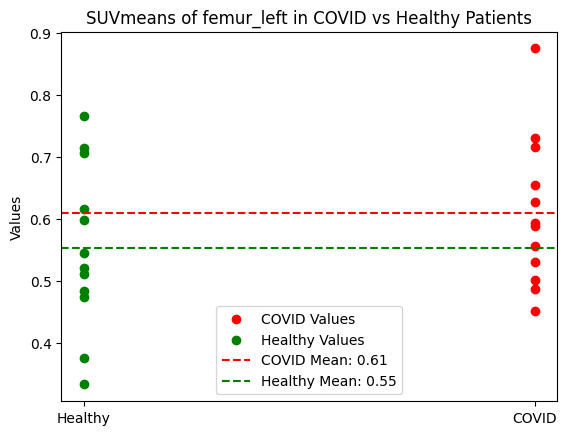

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
covid_vals = COVID_vals
healthy_vals = Healthy_vals
print(covid_vals)
print(healthy_vals)

# Calculate the means
covid_mean = np.mean(covid_vals)
healthy_mean = np.mean(healthy_vals)

# Scatter plot data
covid_x = np.ones(len(covid_vals)) * 2
healthy_x = np.ones(len(healthy_vals))

# Plotting the data
fig, ax = plt.subplots()
ax.scatter(covid_x, covid_vals, color='red', label='COVID Values')
ax.scatter(healthy_x, healthy_vals, color='green', label='Healthy Values')

# Plotting the means
ax.axhline(y=covid_mean, color='red', linestyle='--', label=f'COVID Mean: {covid_mean:.2f}')
ax.axhline(y=healthy_mean, color='green', linestyle='--', label=f'Healthy Mean: {healthy_mean:.2f}')

# Customizing the plot
ax.set_title(f'SUVmeans of {organ} in COVID vs Healthy Patients')
ax.set_xticks([1, 2])
ax.set_xticklabels(['Healthy', 'COVID'])
ax.set_ylabel('Values')
ax.legend()
# Save the figure as a JPEG file
# plt.savefig(f'{organ}_values_comparison.jpg', format='jpg')
plt.show()
plt.close()


### Other: Mass plotting data for all organs to see if there is anything significant

In [20]:
import matplotlib.pyplot as plt
import numpy as np

def plot_organ_stats(organ):
    COVID_vals = []
    Healthy_vals = []

    stat = 'mean'

    for patient, suvs in suv_dict.items():
        if patient.split(" ")[0] == "COVID":
            if patient in earliest_scan_list:
                if organ not in suvs.keys():
                    continue
                avg = extractPatientStats(suvs, organ, stat)
                COVID_vals.append(avg)
        if patient.split(" ")[0] == "Healthy":

            # Remove CJ due to registration mismatch? AMB and HMN have abnormally large SUV uptake.
            if (patient != "Healthy Controls_1341792-Sub023-A01-CJ_20110227.nii.gz" and
                patient != "Healthy Controls_1341792-Sub032-A01-AMB_20110409.nii.gz" and
                patient != "Healthy Controls_1341792-Sub034-A01-HMN_20110401.nii.gz"):
                if organ not in suvs.keys():
                    continue
                avg = extractPatientStats(suvs, organ, stat)
                Healthy_vals.append(avg)

    covid_mean = np.mean(COVID_vals)
    healthy_mean = np.mean(Healthy_vals)

    # Scatter plot data
    covid_x = np.ones(len(COVID_vals)) * 2
    healthy_x = np.ones(len(Healthy_vals))

    # Plotting the data
    fig, ax = plt.subplots()
    ax.scatter(covid_x, COVID_vals, color='red', label='COVID Values')
    ax.scatter(healthy_x, Healthy_vals, color='green', label='Healthy Values')

    # Plotting the means
    ax.axhline(y=covid_mean, color='red', linestyle='--', label=f'COVID Mean: {covid_mean:.2f}')
    ax.axhline(y=healthy_mean, color='green', linestyle='--', label=f'Healthy Mean: {healthy_mean:.2f}')

    # Customizing the plot
    ax.set_title(f'SUVmeans of {organ} in COVID vs Healthy Patients')
    ax.set_xticks([1, 2])
    ax.set_xticklabels(['Healthy', 'COVID'])
    ax.set_ylabel('Values')
    ax.legend()
    # Save the figure as a JPEG file
    plt.savefig(f'{organ}_values_comparison.jpg', format='jpg')
    plt.close()

# List of organs to plot
organs = ['heart', 'spleen', 'liver', 'stomach', 'pancreas', 'brain']


#ignore = ['background', 'gallbladder', 'prostate','adrenal_gland_left','kidney_cyst_left','kidney_cyst_right','portal_vein_and_splenic_vein']

# Generate a plot for each organ
for organ in organs:
    plot_organ_stats(organ)